<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Explaining Language Models using SMILE </b></div>

Large language models like GPT, LLAMA, and Claude have become incredibly powerful at generating text, but they are still black boxes, so it is hard to understand how they decide what to say. That lack of transparency can be problematic, especially in fields where trust and accountability matter. To help with this, we introduce SMILE, a new method that explains how these models respond to different parts of a prompt. SMILE is model-agnostic and works by slightly changing the input, measuring how the output changes, and then highlighting which words had the most impact. Create simple visual heat maps showing which parts of a prompt matter the most. We tested SMILE on several leading LLMs and used metrics such as accuracy, consistency, stability, and fidelity to show that it gives clear and reliable explanations. By making these models easier to understand, SMILE brings us one step closer to making AI more transparent and trustworthy.

In this notebook, we apply SMILE to GPT-3.5 using the sentence: "What is the meaning of life?" to demonstrate its effectiveness.

# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Required Libraries</b></div>

In [1]:
# !pip install -q openai~=2.8.1 sentence-transformers~=5.1.2 pot~=0.9.6 scipy~=1.16.3 matplotlib~=3.10.0 gensim~=4.4.0 scikit-learn~=1.6.1 numpy~=2.0.2 pandas~=2.2.2 python-dotenv~=1.2.1

In [2]:
# Installation
%pip install -q openai~=2.8.1 numpy~=2.0.2 matplotlib~=3.10.0 scikit-learn~=1.6.1 gensim~=4.4.0 pot~=0.9.6 python-dotenv~=1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.6 MB/s eta 0:00:00


In [3]:
import os
import re
import logging

from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gensim.downloader as api
from gensim.models import KeyedVectors
from dotenv import load_dotenv

# Configure logger

In [4]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Load Env vars

In [16]:
# Load OpenAI API key
load_dotenv()

True

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>GPT interaction</b></div>

In [17]:
def gpt_answer(
    client: OpenAI,
    prompt: str,
    model: str = "gpt-3.5-turbo-instruct",
    max_tokens: int = 200,
    temperature: float = 0.0
) -> str:
    """Generate a full natural-language GPT answer.

    Supports both instruct-style models (using completions) and
    reasoning models (using responses.create).

    Args:
        client (OpenAI): OpenAI client instance.
        prompt (str): The input prompt.
        model (str): Model name.
        max_tokens (int): Maximum output token count.
        temperature (float): Sampling temperature (ignored for
            reasoning models).

    Returns:
        str: The generated text output. Returns an empty string on
            error.
    """
    is_reasoning = model.startswith(("o1", "o3", "o4", "gpt-5"))

    try:
        if is_reasoning:
            # Reasoning models use responses.create
            resp = client.responses.create(
                model=model,
                input=prompt,
                max_output_tokens=max_tokens,
                reasoning_effort="low"
            )
            return resp.output_text.strip()

        # Instruct-type models use completions.create
        resp = client.completions.create(
            model=model,
            prompt=prompt,
            max_tokens=max_tokens,
            temperature=temperature
        )
        return resp.choices[0].text.strip()

    except Exception as exc:
        logger.error("GPT answer error: %s", exc)
        return ""


def gpt_score(
    client: OpenAI,
    prompt: str,
    model: str = "gpt-3.5-turbo-instruct",
    max_tokens: int = 10,
    temperature: float = 0.0
) -> str:
    """Request GPT to return a single numeric score.

    Automatically handles both instruct models and reasoning models.
    For reasoning models, temperature is disabled and the call is
    routed through responses.create.

    Args:
        client (OpenAI): OpenAI client instance.
        prompt (str): The prompt containing the scoring instruction.
        model (str): Model name.
        max_tokens (int): Maximum tokens for the numeric output.
        temperature (float): Sampling temperature (ignored for
            reasoning models).

    Returns:
        str: The numeric score as text. Returns "0" on error.
    """
    is_reasoning = model.startswith(("o1", "o3", "o4", "gpt-5"))

    final_prompt = (
        prompt + "\nRespond with a single number only. No explanation."
    )

    try:
        if is_reasoning:
            resp = client.responses.create(
                model=model,
                input=final_prompt,
                max_output_tokens=max_tokens,
                reasoning_effort="low"
            )
            return resp.output_text.strip()

        resp = client.completions.create(
            model=model,
            prompt=final_prompt,
            max_tokens=max_tokens,
            temperature=temperature
        )
        return resp.choices[0].text.strip()

    except Exception as exc:
        logger.error("GPT score error: %s", exc)
        return "0"

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b> Prompt Perturbation and GPT Response Analysis</b></div>

We generate 64 random perturbations of the original prompt by selectively including or excluding words. Each perturbed prompt is sent to GPT-3.5-turbo, and the resulting one-word outputs are collected.

This helps analyze the model’s sensitivity to different input combinations and prepares data for attribution scoring.

In [7]:
def apply_binary_mask(
    text_list: list[str],
    mask: tuple[int, ...],
    rng: np.random.Generator
) -> list[str]:
    """Apply a binary mask to a list of words and ensure minimum word count.

    The mask selects words where a `1` indicates inclusion. If the mask
    includes fewer than two valid words, additional random words from the
    original text are added to preserve semantic stability.

    Args:
        text_list (list[str]): Tokenized original text.
        mask (tuple[int, ...]): Binary mask indicating selected words.
        rng (np.random.Generator): Random generator for selecting fallback
            words.

    Returns:
        list[str]: The perturbed list of words.
    """
    selected = [
        w for w, flag in zip(text_list, mask)
        if flag == 1 and w.strip() != ""
    ]

    if len(selected) < 2:
        needed = 2 - len(selected)
        candidates = [w for w in text_list if w.strip() != ""]
        extra = rng.choice(candidates, needed, replace=False)
        result = list(set(selected + list(extra)))
    else:
        result = list(set(selected))

    return result


def generate_perturbations(
    text: str,
    num_perturb: int = 64,
    seed: int = 1024
) -> tuple[list[str], list[tuple]]:
    """Generate unique binary perturbations and perturbed text versions.

    Args:
        text (str): Original input text.
        num_perturb (int): Number of perturbations to generate.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple[list[str], list[tuple]]:
            - List of perturbed texts (Responses)
            - List of binary perturbation vectors (Perturbations)
    """
    words = text.split()
    text_list = words.copy()
    num_words = len(words)

    rng = np.random.default_rng(seed)

    responses = []
    perturbations = []
    unique_perturbations = set()

    attempts = 0
    max_attempts = num_perturb * 10

    # Loop for unique perturbations only
    while len(unique_perturbations) < num_perturb and attempts < max_attempts:
        p = tuple(rng.binomial(1, 0.5, size=num_words))

        if p not in unique_perturbations and sum(p) > 0:
            unique_perturbations.add(p)
            perturbed_txt = apply_binary_mask(text_list, p, rng)
            corpus = " ".join(perturbed_txt)

            responses.append(corpus)
            perturbations.append(p)

            logger.info(
                "Perturbation: %s, Perturbed Text: %s", p, corpus
            )

        attempts += 1

    # If more perturbations are needed, allow repeats by sampling
    # from unique_perturbations
    while len(responses) < num_perturb:
        p = rng.choice(list(unique_perturbations))
        perturbed_txt = apply_binary_mask(text_list, p, rng)
        corpus = " ".join(perturbed_txt)

        responses.append(corpus)
        perturbations.append(p)

        logger.info(
            "Perturbation (reused): %s, Perturbed Text: %s", p, corpus
        )

    return responses, perturbations


def query_gpt_for_perturbations(
        client,
        model: str,
        responses: list[str],
        max_tokens: int = 10,
        temperature: float = 0.0
) -> list[tuple[str, str]]:
    """Query GPT for each perturbed text and return (input, output) pairs.

    Args:
        client: OpenAI client instance.
        model (str): GPT model name.
        responses (list[str]): Perturbed text inputs.
        max_tokens (int): Max tokens for GPT response.
        temperature (float): Sampling temperature.

    Returns:
        list[tuple[str, str]]: List of (perturbed_input, gpt_output).
    """
    gpt_outputs = []

    for text in responses:
        logger.info("Querying GPT with perturbed text: %s", text)

        gpt_resp = gpt_score(
            client=client,
            prompt=text,
            model=model,
            max_tokens=max_tokens,
            temperature=temperature
        )

        gpt_outputs.append((text, gpt_resp))

    for i, (inp, out) in enumerate(gpt_outputs, 1):
        logger.info("Perturbation %d:", i)
        logger.info("Input: %s", inp)
        logger.info("GPT Output: %s", out)
        logger.info("-" * 50)

    return gpt_outputs


# Word2Vec model

In [8]:
def load_google_news_vectors():
    # First try gensim downloader (fastest & simplest)
    try:
        print("Trying to load 'word2vec-google-news-300' via gensim.api...")
        return api.load("word2vec-google-news-300")
    except Exception:
        print("Gensim API unavailable — downloading manually...")

    # Manual fallback (public mirror)
    url = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
    local_path = "GoogleNews-vectors-negative300.bin.gz"
    extracted_path = "GoogleNews-vectors-negative300.bin"

    # Download if missing
    if not os.path.exists(local_path):
        import urllib.request
        print("Downloading GoogleNews vectors...")
        urllib.request.urlretrieve(url, local_path)

    # Extract if needed
    if not os.path.exists(extracted_path):
        import gzip
        import shutil
        print("Extracting .gz file...")
        with gzip.open(local_path, "rb") as f_in:
            with open(extracted_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

    print("Loading Word2Vec model...")
    return KeyedVectors.load_word2vec_format(extracted_path, binary=True)

# Text utilities

In [9]:
def clean_text(text: str) -> str:
    """Clean text by removing punctuation, lowering, and stripping whitespace.

    Args:
        text (str): Input text.

    Returns:
        str: Cleaned text.
    """
    cleaned = re.sub(r"[^\w\s]", "", text.lower())
    return cleaned.strip()


def safe_wmdistance(model, text1: str, text2: str) -> float:
    """Compute Word Mover's Distance using only in-vocabulary cleaned words.

    Args:
        model: Word2Vec model with wmdistance().
        text1 (str): First text.
        text2 (str): Second text.

    Returns:
        float: WMD distance or 1.0 if texts have no valid tokens.
    """
    words1 = [w for w in clean_text(text1).split() if w in model]
    words2 = [w for w in clean_text(text2).split() if w in model]
    if not words1 or not words2:
        return 1.0
    return model.wmdistance(words1, words2)

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Compute Distances & Semantic Similarity Using Word Mover’s Distance (WMD)</b></div>

To quantify how semantically different each GPT-generated output is from the original response, we use the Word Mover’s Distance (WMD) metric with a pre-trained Word2Vec model (GoogleNews).  
We also compute distances between the original prompt and each perturbed version.

This allows us to evaluate how much meaning is preserved across the perturbed prompts.


In [10]:
def compute_wmd_scores(model, original: str, gpt_pairs: list) -> list:
    """Compute safe WMD distances between original output and perturbed outputs.

    Args:
        model: Word2Vec model.
        original (str): Original GPT output.
        gpt_pairs (list): List of (perturbed_text, gpt_output).

    Returns:
        list: List of (perturbed_text, distance).
    """
    scores = []
    for text, resp in gpt_pairs:
        dist = safe_wmdistance(model, original, resp)
        scores.append((text, dist))
    return scores


def normalize_similarities(wmd_scores: list) -> list:
    """Normalize distances into similarity scores between 0 and 1.

    Args:
        wmd_scores (list): List of (text, distance).

    Returns:
        list: List of (text, similarity).
    """
    values = [d for _, d in wmd_scores]
    min_val, max_val = min(values), max(values)
    out = []

    for text, dist in wmd_scores:
        if max_val == min_val:
            # All similarities identical when all distances are the same
            sim = 1.0
        else:
            # Convert normalized distance to similarity
            sim = 1 - (dist - min_val) / (max_val - min_val)
        out.append((text, sim))

    for text, sim in out:
        logger.info("Perturbed Text: %s", text)
        logger.info("Similarity Score: %.4f", sim)
        logger.info("-" * 50)

    return out

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#003d99;overflow:hidden"><b>Coefficients and Visual Output of the SMILE Framework</b></div>

To understand which words in the original prompt most influence the model’s behavior, we fit a weighted linear regression model using the perturbation matrix and normalized similarity scores.

The weights are calculated based on the semantic distances (WMD) between perturbed and original outputs, using a Gaussian kernel.

The resulting coefficients represent the contribution of each token in the original prompt to the output similarity.

We visualize these coefficients as a text-based heatmap, where more influential words are highlighted with stronger colors.

In [11]:
def fit_weighted_regression(
    perturbations: list,
    similarities: list,
    wmd_scores: list
) -> tuple:
    """Fit weighted linear regression using WMD distances.

    Args:
        perturbations (list): List of binary perturbation vector
            (Perturbations)
        similarities (list): List of (text, similarity).
        wmd_scores (list): List of (text, distance).

    Returns:
        tuple: (linear_model, coefficients, weights)
    """
    # Convert Perturbations to a NumPy array
    perturb_vecs = np.vstack(perturbations)  # Stack all perturbation vectors vertically

    dvals = np.array([d for _, d in wmd_scores])
    kernel_w = 0.25
    weights = np.sqrt(np.exp(-(dvals ** 2) / (kernel_w ** 2)))

    logger.debug("Weights:\n{weights}", weights)
    logger.debug("Perturbations:\n{perturbations}", perturb_vecs)

    y = np.array([s for _, s in similarities])

    linear_model = LinearRegression()
    linear_model.fit(perturb_vecs, y, sample_weight=weights)

    coeffs = linear_model.coef_
    logger.info("Regression coefficients: %s", coeffs)

    return linear_model, coeffs, weights


# Metrics

In [12]:
def compute_regression_metrics(
    linear_model: LinearRegression,
    coeffs: np.ndarray,
    weights: np.ndarray,
    similarities: list,
    perturbations: list
) -> dict:
    """Compute weighted regression metrics.

    Args:
        linear_model: Trained LinearRegression model.
        coeffs (np.ndarray): Regression coefficients.
        weights (np.ndarray): Sample weights.
        similarities (list): (text, similarity).
        perturbations (list): List of binary perturbation vectors.

    Returns:
        dict: Metrics including weighted R2, L1/L2 losses.
    """
    y_true = np.array([s for _, s in similarities])
    y_pred = linear_model.predict(perturbations).ravel()

    # Base regression metrics
    mse = mean_squared_error(y_true, y_pred, sample_weight=weights)
    mae = mean_absolute_error(y_true, y_pred, sample_weight=weights)

    # Mean loss
    mean_loss = abs(np.mean(y_true) - np.mean(y_pred))

    # L1 and L2 losses
    diff = y_true - y_pred
    mean_l1 = np.mean(np.abs(diff))
    mean_l2 = np.mean(diff ** 2)

    # Weighted L1 & L2
    n = len(y_true)
    weighted_l1 = np.sum(weights * np.abs(diff)) / n
    weighted_l2 = np.sum(weights * (diff ** 2)) / n

    # Weighted R² & Adjusted
    p = len(coeffs)
    f_mean = np.average(y_true, weights=weights)
    ss_tot = np.sum(weights * (y_true - f_mean) ** 2)
    ss_res = np.sum(weights * (y_true - y_pred) ** 2)
    weighted_r2 = 1 - ss_res / ss_tot

    weighted_adj_r2 = 1 - (1 - weighted_r2) * (n - 1) / (n - p - 1)

    return {
        "Mean Squared Error (MSE)": mse,
        "Mean Absolute Error (MAE)": mae,
        "Mean Loss (Lm)": mean_loss,
        "Mean L1 Loss": mean_l1,
        "Mean L2 Loss": mean_l2,
        "Weighted L1 Loss": weighted_l1,
        "Weighted L2 Loss": weighted_l2,
        "Weighted R-squared (R²ω)": weighted_r2,
        "Weighted Adjusted R-squared (R^²ω)": weighted_adj_r2,
    }


def print_metrics(metrics):
    print('-' * 100)
    print("Fidelity:")
    for name, value in metrics.items():
        print(f"{name}: {value}")
    print('-' * 100)


# Heatmap visualization

In [13]:
def plot_text_heatmap(
    words: list,
    scores: np.ndarray,
    title: str = "",
    width: float = 10.0,
    height: float = 0.4,
    verbose: int = 0,
    max_word_per_line: int = 20,
    word_spacing: int = 20,
    score_fontsize: int = 10,
    save_path: str | None = None
) -> None:
    """Plot a heatmap-like visualization over text tokens.

    Each token is shown inside a colored box based on its score, with the
    numeric score displayed underneath it.

    Args:
        words (list): List of text tokens.
        scores (np.ndarray): Array of per-token scores.
        title (str): Title shown on the plot.
        width (float): Figure width in inches.
        height (float): Figure height in inches.
        verbose (int): If 0, hide axes (clean output).
        max_word_per_line (int): Max number of tokens per visual line.
        word_spacing (int): Horizontal spacing between tokens.
        score_fontsize (int): Font size for numeric score labels.
        save_path (str | None): Optional save path.

    Returns:
        None
    """
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc="left")

    # Color map normalization
    cmap = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
    cmap.set_clim(0, 1)

    denom = np.max(np.abs(scores))
    if denom == 0:
        denom = 1e-8   # avoid division by zero
    normalized = 0.5 * scores / denom + 0.5

    canvas = ax.figure.canvas
    transform = ax.transData

    y = -0.2  # starting y

    for i, (word, score, ns) in enumerate(zip(words, scores, normalized)):
        r, g, b, _ = cmap.to_rgba(ns, bytes=True)
        color = f"#{r:02x}{g:02x}{b:02x}"

        # draw token
        txt = ax.text(
            0.0, y, word,
            bbox={
                "facecolor": color,
                "pad": 5.0,
                "linewidth": 1,
                "boxstyle": "round,pad=0.5"
            },
            transform=transform,
            fontsize=14
        )
        txt.draw(canvas.get_renderer())
        ex = txt.get_window_extent()

        # draw numeric score under token
        score_txt = ax.text(
            0.01,
            y - 1.0,
            f"{score:.2f}",
            transform=transform,
            fontsize=score_fontsize,
            ha="center"
        )
        score_txt.draw(canvas.get_renderer())

        # new transform for next token
        if (i + 1) % max_word_per_line == 0:
            y -= 2.5
            transform = ax.transData
        else:
            transform = transforms.offset_copy(
                txt._transform,
                x=ex.width + word_spacing,
                units="dots"
            )

    if verbose == 0:
        ax.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


# High-level pipeline

In [14]:
def run_pipeline(
    model: str,
    prompt: str,
    max_tokens: int = 200,
    temperature: float = 0.0,
    plot_heatmap: bool = True
) -> dict:
    """Run full GSMILE pipeline from GPT query to regression and metrics.

    Args:
        model (str): GPT model name.
        prompt (str): Original prompt.
        max_tokens (int): Max tokens for GPT.
        temperature (float): Sampling temperature.
        plot_heatmap (bool): Whether to generate heatmap.

    Returns:
        dict: Results including WMD scores, similarities, coefficients,
            metrics.
    """
    client = OpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
    )

    logger.info("Querying GPT for original response...")
    original = gpt_answer(
        client, prompt, model, max_tokens, temperature
    )

    logger.info("Generate perturbations...")
    responses, perturbations = generate_perturbations(text=prompt)

    logger.info("Querying GPT for perturbations...")
    gpt_pairs = query_gpt_for_perturbations(
        client, model, responses, max_tokens=10, temperature=temperature
    )

    logger.info("Loading Google news Word2Vec model...")
    model_txt = load_google_news_vectors()
    # Precompute and cache vector norms to speed up similarity/WMD calculations
    model_txt.fill_norms(force=True)

    logger.info("Computing WMD scores...")
    wmd_scores = compute_wmd_scores(model_txt, original, gpt_pairs)

    logger.info("Normalizing similarities...")
    sims = normalize_similarities(wmd_scores)

    logger.info("Fitting regression model...")
    linear_model, coeffs, weights = fit_weighted_regression(
        perturbations, sims, wmd_scores
    )

    logger.info("Computing metrics...")
    metrics = compute_regression_metrics(
        linear_model=linear_model,
        coeffs=coeffs,
        weights=weights,
        similarities=sims,
        perturbations=perturbations,
    )

    if plot_heatmap:
        logger.info("Plotting heatmap...")
        words = prompt.split()
        plot_text_heatmap(words, coeffs, "Text Heatmap")

    return {
        "original_output": original,
        "gpt_pairs": gpt_pairs,
        "wmd_scores": wmd_scores,
        "similarities": sims,
        "coefficients": coeffs,
        "weights": weights,
        "metrics": metrics
    }


# Run pipeline

INFO:__main__:Querying GPT for original response...
INFO:__main__:Generate perturbations...
INFO:__main__:Perturbation: (np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0)), Perturbed Text: meaning of
INFO:__main__:Perturbation: (np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0)), Perturbed Text: What is the of
INFO:__main__:Perturbation: (np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1)), Perturbed Text: What life? the of
INFO:__main__:Perturbation: (np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)), Perturbed Text: is the meaning
INFO:__main__:Perturbation: (np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1)), Perturbed Text: What life?
INFO:__main__:Perturbation: (np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)), Perturbed Text: the life? of is What meaning
INFO:__main__:Perturbation: (np.int64(0), np.int64(0), np.int64(1

Trying to load 'word2vec-google-news-300' via gensim.api...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


INFO:__main__:Computing WMD scores...
INFO:__main__:Normalizing similarities...
INFO:__main__:Perturbed Text: meaning of
INFO:__main__:Similarity Score: 0.6926
INFO:__main__:--------------------------------------------------
INFO:__main__:Perturbed Text: What is the of
INFO:__main__:Similarity Score: 0.3423
INFO:__main__:--------------------------------------------------
INFO:__main__:Perturbed Text: What life? the of
INFO:__main__:Similarity Score: 1.0000
INFO:__main__:--------------------------------------------------
INFO:__main__:Perturbed Text: is the meaning
INFO:__main__:Similarity Score: 0.3327
INFO:__main__:--------------------------------------------------
INFO:__main__:Perturbed Text: What life?
INFO:__main__:Similarity Score: 1.0000
INFO:__main__:--------------------------------------------------
INFO:__main__:Perturbed Text: the life? of is What meaning
INFO:__main__:Similarity Score: 1.0000
INFO:__main__:--------------------------------------------------
INFO:__main__:Per

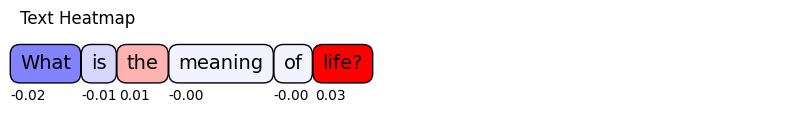

In [18]:
result = run_pipeline(
    model="gpt-3.5-turbo-instruct",
    prompt="What is the meaning of life?",
)

In [19]:
result

{'original_output': 'The meaning of life is a philosophical question that has been debated by many thinkers and scholars throughout history. It is a complex and subjective concept that can have different interpretations and meanings for different individuals. Some believe that the meaning of life is to find happiness and fulfillment, while others believe it is to fulfill a certain purpose or destiny. Some see it as a journey of self-discovery and personal growth, while others see it as a way to contribute to the greater good of society. Ultimately, the meaning of life is a deeply personal and individual concept that can vary greatly from person to person.',
 'gpt_pairs': [('meaning of', 'I am an AI and do not have the'),
  ('What is the of', "I'm sorry, I cannot provide a number"),
  ('What life? the of', '42'),
  ('is the meaning', "I'm sorry, I cannot provide a single"),
  ('What life?', '42'),
  ('the life? of is What meaning', '42'),
  ('the', '42'),
  ('is life?', '42'),
  ('life?

## 📚 References

1. **OpenAI.** (2023). *GPT-3.5 and Instruct Models*.  
   Retrieved from https://platform.openai.com/docs

2. **Kusner, M., Sun, Y., Kolkin, N., & Weinberger, K. Q.** (2015).  
   *From Word Embeddings to Document Distances*.  
   In *Proceedings of the 32nd International Conference on Machine Learning (ICML)*.  
   https://proceedings.mlr.press/v37/kusnerb15.html

3. **Mikolov, T., Chen, K., Corrado, G., & Dean, J.** (2013).  
   *Efficient Estimation of Word Representations in Vector Space*.  
   arXiv:1301.3781 [cs.CL].  
   https://code.google.com/archive/p/word2vec/

4. **Ribeiro, M. T., Singh, S., & Guestrin, C.** (2016).  
   *"Why Should I Trust You?": Explaining the Predictions of Any Classifier*.  
   In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD)*.  
   https://doi.org/10.1145/2939672.2939778

5. **Aslansefat, K., Hashemian, M., Walker, M., Akram, M. N., Sorokos, I., & Papadopoulos, Y.** (2023).  
   *Explaining Black Boxes with a SMILE: Statistical Model-agnostic Interpretability with Local Explanations*.  
   *IEEE Software*, 41(1), 87–97.  
   https://doi.org/10.1109/MS.2023.10112345
